# Sydney Real Estate

The SurfIntoYourHome LLC from Sydney wants to offer a new service to their clients. Similar to the competition from overseas, the company wants to offer a price estimate of a building to their customers. This is supposed to help the customer evaluate wether the pricing of a building is fair or not. In order for the prediction to work the company has provided a dataset under the CC0: Public Domain License from https://www.kaggle.com/datasets/mihirhalai/sydney-house-prices?select=SydneyHousePrices.csv which has been scraped from the web.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(20,10)})

In [3]:
data = pd.read_csv("/home/jovyan/DeepLearningExperiment/data/SydneyHousePrices.csv")

In [4]:
data.shape

(199504, 9)

In [5]:
data.head()

,Date,Id,suburb,postalCode,sellPrice,bed,bath,car,propType
0,2019-06-19,1,Avalon Beach,2107,1210000,4.0,2,2.0,house
1,2019-06-13,2,Avalon Beach,2107,2250000,4.0,3,4.0,house
2,2019-06-07,3,Whale Beach,2107,2920000,3.0,3,2.0,house
3,2019-05-28,4,Avalon Beach,2107,1530000,3.0,1,2.0,house
4,2019-05-22,5,Whale Beach,2107,8000000,5.0,4,4.0,house


The dataset contains 199504 rows and has 9 columns.

In [6]:
data["sellPrice"].max()

2147483647

In [7]:
data.describe()

,Id,postalCode,sellPrice,bed,bath,car
count,199504.00000,199504.000000,1.995040e+05,199350.000000,199504.000000,181353.000000
mean,99752.50000,2196.379155,1.269776e+06,3.516479,1.890669,1.936224
std,57591.98839,193.053467,6.948239e+06,1.066555,0.926001,1.060237
min,1.00000,2000.000000,1.000000e+00,1.000000,1.000000,1.000000
25%,49876.75000,2082.000000,7.200000e+05,3.000000,1.000000,1.000000
50%,99752.50000,2144.000000,9.850000e+05,3.000000,2.000000,2.000000
75%,149628.25000,2211.000000,1.475000e+06,4.000000,2.000000,2.000000
max,199504.00000,4878.000000,2.147484e+09,99.000000,99.000000,41.000000


The dataset contains property that has been sold for 1 AUD up to 2 billion dollar. This is clearly a mistake and during the data cleaning those extreme values will be removed. the lower values for bedrooms, bathrooms and car parking spots seem plausible as they are all 1. However, the max values for bed and bathrooms of 99 seems implausible. The same applies for the car parking with 41. Even if those values are true the company is focused on singles and families and not real estate developers, therefor those values can be excluded from the prediction.

For this purpose the dataset will be filtered to only keep listings with a price lower than or equal to 10 Mio AUD. For the bedrooms, bathrooms and car parking lots a filter of 10 is applied. 

In [8]:
data_filtered = data[data["sellPrice"]<= 10000000]
data_filtered = data_filtered[data_filtered["bed"]<= 10]
data_filtered = data_filtered[data_filtered["bath"]<= 10]
data_filtered = data_filtered[data_filtered["car"]<= 10]

In [9]:
data_filtered.describe()

,Id,postalCode,sellPrice,bed,bath,car
count,180856.000000,180856.000000,1.808560e+05,180856.000000,180856.000000,180856.000000
mean,99088.106886,2204.848382,1.238545e+06,3.576182,1.933649,1.923475
std,57869.443012,194.464316,8.548331e+05,0.963020,0.864519,0.987800
min,1.000000,2000.000000,1.000000e+00,1.000000,1.000000,1.000000
25%,48444.750000,2092.000000,7.200000e+05,3.000000,1.000000,1.000000
50%,99005.500000,2148.000000,9.810000e+05,3.000000,2.000000,2.000000
75%,149570.250000,2213.000000,1.480000e+06,4.000000,2.000000,2.000000
max,199504.000000,4878.000000,1.000000e+07,10.000000,10.000000,10.000000


The resulting dataset appears to be more plausible now. The average real estate object has now a price of roughly 1.2 million AUD, which contains 3.5 bedrooms, almost 2 bathrooms and 2 car parking plots. 

As a next step the year of the sale will be extracted as feature. The prices in the sydney are mostlikely be correlated to the year of the sale.


In [10]:
type(data_filtered["Date"][0])

str

The date is saved as string so the year can be extracted rather easily.

In [11]:
data_filtered["year"] = pd.to_numeric(data_filtered["Date"].str[:4])

In [12]:
data_filtered.groupby("year")["sellPrice"].count()

year
2000        1
2001        8
2002        3
2003       13
2004       57
2005      139
2006      168
2007      694
2008     3292
2009     6980
2010     8029
2011     9037
2012    10484
2013    15881
2014    20869
2015    24024
2016    24231
2017    26155
2018    21971
2019     8820
Name: sellPrice, dtype: int64

Becasue most of the values are in the range from 2009 to 2019, all values before that will be excluded. 2009 will be set as year 1 for the prediction. The idea of setting the date as this type of vaiable is that in general the housing prices are increasing year over year [2]. This is not always true especially in times of crises the prices can drop from the year before. However, most of the time the prices of houses increase year over year. 

In [13]:
data_filtered = data_filtered[data_filtered["year"]>=2009]

In [14]:
data_filtered["year_norm"] = data_filtered["year"] -2008

<AxesSubplot:xlabel='year', ylabel='sellPrice'>

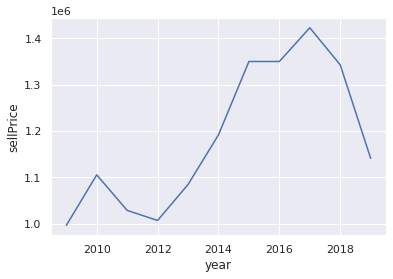

In [15]:
sns.lineplot(x=data_filtered.groupby("year")["sellPrice"].mean().round(0).index[:], y= data_filtered.groupby("year")["sellPrice"].mean().round(0)[:])


The grafic above shows the varation of the average price over the years.

Next the property types will be evaluated.

In [16]:
data_filtered.groupby("propType")["propType"].count()

propType
acreage                     10
duplex/semi-detached      6024
house                   149340
other                      189
terrace                    723
townhouse                14691
villa                     5484
warehouse                   20
Name: propType, dtype: int64

As mentioned before the client is manly interessted in selling housing to people who will actually move in to the property. Therefor warehouses and acreage can be removed as they are not important for this business goal. In addition to this the category other will be removed. THis leaves the property types "duplex/semi-detached","house","townhouse","villa", "terrace".

In [17]:
data_filtered = data_filtered[data_filtered["propType"].isin(["duplex/semi-detached","house","townhouse","villa", "terrace"])]

As a last step the location will be taken into consideration. Location is most likely one key factor of the price of housing. There are two possible features that can be used to take this into consideration. Option one is to use the suburb. The problem here is that there are 669 unique suburbs in the dataset. This is most likely to fine in granularity. Therefor two datasets will be generated. One with the raw suburbs as input and one with the suburbs clustered with the average number of bedrooms, bathrooms and average price of the suburb. The second option from the dataset is to use teh ZIP code. This however is not as fine in granularity and therefor most likely not as well suited for this analysis. ZIP codes will be dropped later.

In [18]:

data_all_suburbs = pd.get_dummies(data_filtered,drop_first=True, columns=["propType","suburb"])
data_all_suburbs_final = data_all_suburbs.dropna(how="any")

In [19]:
data_all_suburbs_final.shape

(176262, 681)

This is the first dataset for experimentation with all suburbs as dummy and all the NA values removed, resulting in a dataset with 176,262 properties for the models to train on. It is made up of 681 features.

In [20]:
suburbs = data_filtered.groupby("suburb")["sellPrice", "bed", "bath"].mean()

/tmp/ipykernel_74/33837120.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  suburbs = data_filtered.groupby("suburb")["sellPrice", "bed", "bath"].mean()


In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import k_means
scaler = MinMaxScaler()
X = scaler.fit_transform(suburbs)
Y = k_means(X,n_clusters=20, random_state = 42)

In [22]:
suburbs["cluster"] = Y[1]

In [23]:
suburbs = suburbs.reset_index()

In [24]:
suburbs.drop(["sellPrice", "bed", "bath"], axis=1, inplace=True)

In [25]:
data_clustered_suburbs = data_filtered.merge(suburbs, on="suburb")

In [26]:
data_clustered_suburbs.drop(["Date","Id","suburb", "postalCode", "year"], axis=1,inplace=True)


In [27]:
data_clustered_suburbs_final = pd.get_dummies(data_clustered_suburbs,drop_first=True, columns=["propType","cluster"] )

In [28]:
data_clustered_suburbs_final

,sellPrice,bed,bath,car,year_norm,propType_house,propType_terrace,propType_townhouse,propType_villa,cluster_1,...,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19
0,1210000,4.0,2,2.0,11,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2250000,4.0,3,4.0,11,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1530000,3.0,1,2.0,11,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1510000,3.0,1,2.0,11,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1500000,5.0,4,4.0,11,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176257,1610000,5.0,3,6.0,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
176258,1330000,4.0,2,2.0,7,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
176259,1100000,5.0,3,2.0,7,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
176260,850000,4.0,2,2.0,6,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Baseline

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math

In [59]:
Results = []

In [53]:
Y = pd.DataFrame(data_clustered_suburbs_final["sellPrice"])
avgSellPrice = data_clustered_suburbs_final["sellPrice"].mean()
Y["avgSellPrice"] = avgSellPrice

In [57]:
RMSE = math.sqrt(mean_squared_error(Y["sellPrice"],Y["avgSellPrice"]))
MAE = mean_absolute_error(Y["sellPrice"],Y["avgSellPrice"])
MAPE = mean_absolute_percentage_error(Y["sellPrice"],Y["avgSellPrice"])


In [60]:
Results.append({"name":"baseline","scores":{"RMSE":RMSE,"MAE":MAE,"MAPE":MAPE}})

## Machine Learning 

## Neuronales Netz

[1] https://www.smh.com.au/property/news/it-s-crazy-sydney-house-prices-surge-55-per-cent-in-less-than-three-years-20220210-p59vck.html, 15.06.2022.  
[2] https://www.cnbc.com/2017/06/23/how-much-housing-prices-have-risen-since-1940.html, 15.06.2022.